In [2]:
# Avellaneda and Stoikov model calibration

AvellanedaStoikov parameter calibration for gamma ray HFT trading bot

In [1]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

plt.rc('figure', figsize=(20, 5))

## Introduction

The HFT trading bot uses the finite horizon Avellaneda and Stoikov model with the following formulation:

**assmue order arrial rate**
$$\lambda^a(\delta)=\lambda^b(\delta)=Ae^{-k\delta}$$

**reservation price**

$$r(s,t)=s-q\gamma\sigma^2(T-t)$$

**spread**
$$\delta=\delta^a+\delta^b=\gamma\sigma^2(T-t)+\frac{2}{\gamma}\ln(1+\frac{\gamma}{k})$$

**bid price**
$$r^b(s,q,t)=r(s,t)-\frac{1}{2}\delta$$

**ask price**
$$r^a(s,q,t)=r(s,t)+\frac{1}{2}\delta$$

**The following contents in this notebook will calibrate the following parameters**:

1. sigma
2. k
3. gamma

For more information you can refer to the original [paper](https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book). It is worth noting that calibration of the above parameters are non-trivial, they are active research fields with various on going studies. This notebook only provide one (simple) method for calibrating the model.

## Playground

This is a implementation of the model in python, you can plug in different parameters and see the outputs of the model to get a tangible feeling of the model

In [11]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

T = 1.0
t = 0
dt = T - t
gamma = 0.1
sigma = 0.020959183855677677
k = 0.11592074038480511
q = -1000
s = 3.180247117563019

r = s - q * gamma * sigma**2 * dt

# Reserve spread
r_spread = (gamma * sigma**2 * dt + (2 / gamma) * math.log(1+gamma/k)) * 0.0001
# optimal quotes
ra = r + r_spread/2
rb = r - r_spread/2
print("ask quote: ", ra)
print("", ra - s)
print("bid quote: ", rb)

ask quote:  3.2247978632617227
 0.044550745698703764
bid quote:  3.2235538494435354


## Trading data

For illustration purpose, we will only one day's XBTUSD quoting data and trading data. In practise you should use a much longer sample of historical prices and trades. You can get all historical data here: https://public.bitmex.com/

In [9]:
quotes = pd.read_csv("./data/XBTUSD_quote_sample.csv")
trades = pd.read_csv("./data/XBTUSD_trade_sample.csv")
quotes.loc[:, 'timestamp'] = pd.to_datetime(quotes.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")
trades.loc[:, 'timestamp'] = pd.to_datetime(trades.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")

FileNotFoundError: [Errno 2] No such file or directory: './data/XBTUSD_quote_sample.csv'

In [7]:
# calculate mid price by averaging best bid and best ask
# print(quotes.bidPrice + quotes.askPrice)
quotes.loc[:, 'midPrice'] = (quotes.bidPrice + quotes.askPrice) / 2

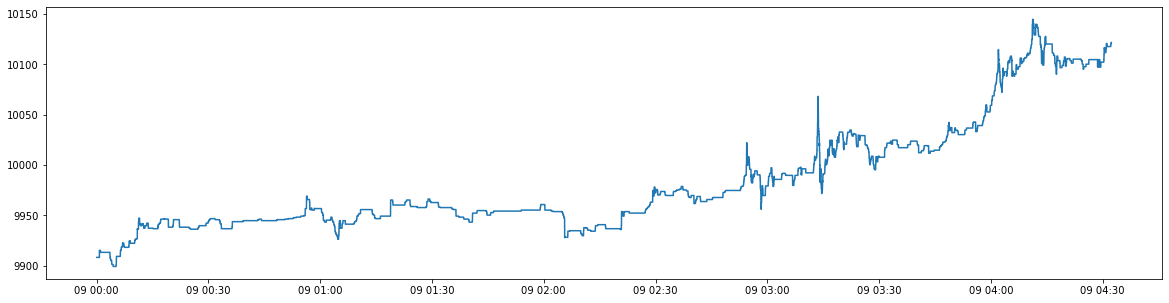

In [20]:
# reset the index to timestamp and plot the price change for the day
Xt = quotes.set_index('timestamp').midPrice
plt.plot(Xt)

## Parameter estimation: sigma

In this chapter we calibrate the model parameter sigma, which is measures the volitility of an assumed brownian motion. We use the first solution proposed here:
https://alexioannides.com/2019/01/18/stochastic-process-calibration-using-bayesian-inference-probabilistic-programs/

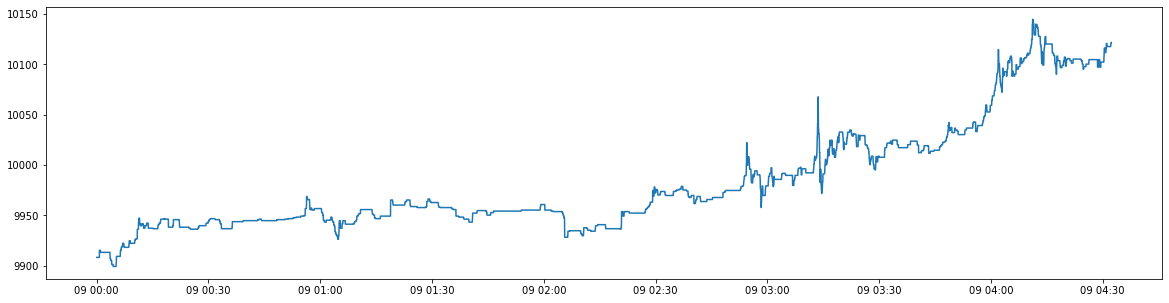

In [29]:
# resample prices with 1 second fixed interval
resample = Xt.resample('1S').last().bfill()
plt.plot(resample)

<AxesSubplot:xlabel='midPrice', ylabel='Count'>

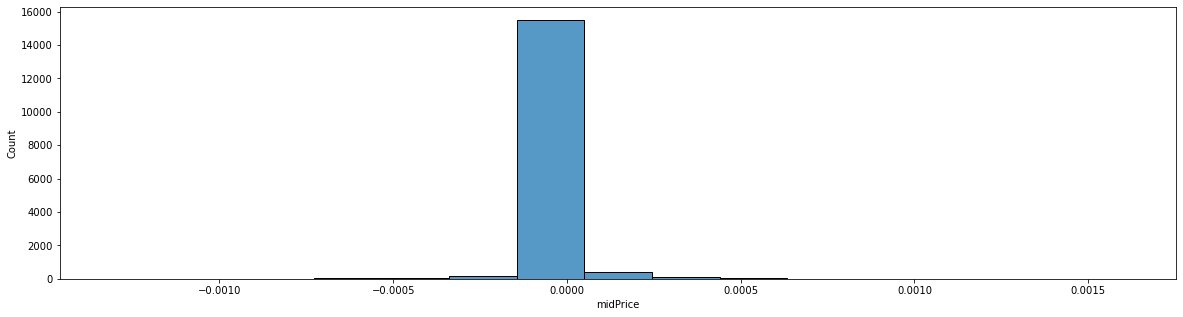

In [30]:
log_norm = np.log(resample).diff(1).dropna()
sns.histplot(log_norm)

In [31]:
# calculate deviation
sigma = log_norm.std() * np.sqrt(3600*24)
print(sigma)

0.020959183855677677


## Parameter esitmation: k

Parameter k measures the probability of an order being executed at a given tick, here will estimate k by counting trades in **n** samples with each sample being a 10 seconds time period. For more information you can read Joaquin FERNANDEZ TAPIA's PhD thesis:
[Modeling, optimization and estimation for the on-line control of trading algorithms in limit-order markets](https://www.researchgate.net/publication/284900784_Modeling_optimization_and_estimation_for_the_on-line_control_of_trading_algorithms_in_limit-order_markets) Chapter 4

![captured liquidity](./footage/captured_liquidity.png)

### Average volume quantity

We will find the average marketable order size

In [32]:
# we use the median quantity as the average volume quantity
trades_filtered = trades[trades['size'] > 25] # filter out small trades
trades_filtered['size'].describe()

count    4.315130e+05
mean     6.244867e+03
std      2.491747e+04
min      2.600000e+01
25%      7.500000e+01
50%      5.000000e+02
75%      3.183000e+03
max      3.897981e+06
Name: size, dtype: float64

So the average volume quantity is 50 percentile: 500

### Estimate trade intensity

In [33]:
# rounding util functions

def round_up(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return x + tick - remainder

def round_down(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return math.floor(x / tick) * tick

In [34]:
# TODO: this part is really slow, could be more efficient(pre-allocate memory) and use parallel processing to speed things up

# sample time window in seconds
dT = 10
# number of samples
n = 0
# initial timestamp
T0 = quotes.iloc[0, :].timestamp
# end timestamp
T_final = quotes.iloc[-1, :].timestamp
# min tick size
tick = 0.5
# measured spread range
r = 40 # 40*0.5=20

T_start = T0
T_end = T_start + pd.Timedelta(seconds=dT)

ask_side_hits = np.array([])
bid_side_hits = np.array([])

while T_end < T_final:

    print("Processing timestamp: ", T_start)
    # reference price S(t)
    St = quotes[quotes.timestamp >= T_start].iloc[0, :].midPrice
    # ask side
    St_ask = round_down(St, tick)
    # get marketable bids
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Buy') # side is "Buy"
    criteria_4 = (trades_filtered.price > St_ask) # price must be higher than St_ask
    criteria_5 = (trades_filtered.price <= St_ask + (r * tick)) # price must be lower than the measured spread range
    m_bids = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_bids.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_bids.price.unique(), St_ask), tick)
        ask_side_hits = np.hstack([ask_side_hits, hits])

    # bid side
    St_bid = round_up(St, tick)
    # get marketable asks
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Sell') # side is "Sell"
    criteria_4 = (trades_filtered.price < St_bid) # price must be lower than St_bid
    criteria_5 = (trades_filtered.price >= St_bid - (r * tick)) # price must be higher than the measured spread range
    m_asks = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_asks.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_asks.price.unique(), St_bid), -tick)
        bid_side_hits = np.hstack([bid_side_hits, hits])

    T_start = T_start + pd.Timedelta(seconds=dT)
    T_end = T_end + pd.Timedelta(seconds=dT)
    n = n + 1
    # break

print('done with {0} samples'.format(n))

Processing timestamp:  2020-02-09 00:00:02.895058
Processing timestamp:  2020-02-09 00:00:12.895058
Processing timestamp:  2020-02-09 00:00:22.895058
Processing timestamp:  2020-02-09 00:00:32.895058
Processing timestamp:  2020-02-09 00:00:42.895058
Processing timestamp:  2020-02-09 00:00:52.895058
Processing timestamp:  2020-02-09 00:01:02.895058
Processing timestamp:  2020-02-09 00:01:12.895058
Processing timestamp:  2020-02-09 00:01:22.895058
Processing timestamp:  2020-02-09 00:01:32.895058
Processing timestamp:  2020-02-09 00:01:42.895058
Processing timestamp:  2020-02-09 00:01:52.895058
Processing timestamp:  2020-02-09 00:02:02.895058
Processing timestamp:  2020-02-09 00:02:12.895058
Processing timestamp:  2020-02-09 00:02:22.895058
Processing timestamp:  2020-02-09 00:02:32.895058
Processing timestamp:  2020-02-09 00:02:42.895058
Processing timestamp:  2020-02-09 00:02:52.895058
Processing timestamp:  2020-02-09 00:03:02.895058
Processing timestamp:  2020-02-09 00:03:12.895058


Processing timestamp:  2020-02-09 00:27:22.895058
Processing timestamp:  2020-02-09 00:27:32.895058
Processing timestamp:  2020-02-09 00:27:42.895058
Processing timestamp:  2020-02-09 00:27:52.895058
Processing timestamp:  2020-02-09 00:28:02.895058
Processing timestamp:  2020-02-09 00:28:12.895058
Processing timestamp:  2020-02-09 00:28:22.895058
Processing timestamp:  2020-02-09 00:28:32.895058
Processing timestamp:  2020-02-09 00:28:42.895058
Processing timestamp:  2020-02-09 00:28:52.895058
Processing timestamp:  2020-02-09 00:29:02.895058
Processing timestamp:  2020-02-09 00:29:12.895058
Processing timestamp:  2020-02-09 00:29:22.895058
Processing timestamp:  2020-02-09 00:29:32.895058
Processing timestamp:  2020-02-09 00:29:42.895058
Processing timestamp:  2020-02-09 00:29:52.895058
Processing timestamp:  2020-02-09 00:30:02.895058
Processing timestamp:  2020-02-09 00:30:12.895058
Processing timestamp:  2020-02-09 00:30:22.895058
Processing timestamp:  2020-02-09 00:30:32.895058


Processing timestamp:  2020-02-09 00:54:42.895058
Processing timestamp:  2020-02-09 00:54:52.895058
Processing timestamp:  2020-02-09 00:55:02.895058
Processing timestamp:  2020-02-09 00:55:12.895058
Processing timestamp:  2020-02-09 00:55:22.895058
Processing timestamp:  2020-02-09 00:55:32.895058
Processing timestamp:  2020-02-09 00:55:42.895058
Processing timestamp:  2020-02-09 00:55:52.895058
Processing timestamp:  2020-02-09 00:56:02.895058
Processing timestamp:  2020-02-09 00:56:12.895058
Processing timestamp:  2020-02-09 00:56:22.895058
Processing timestamp:  2020-02-09 00:56:32.895058
Processing timestamp:  2020-02-09 00:56:42.895058
Processing timestamp:  2020-02-09 00:56:52.895058
Processing timestamp:  2020-02-09 00:57:02.895058
Processing timestamp:  2020-02-09 00:57:12.895058
Processing timestamp:  2020-02-09 00:57:22.895058
Processing timestamp:  2020-02-09 00:57:32.895058
Processing timestamp:  2020-02-09 00:57:42.895058
Processing timestamp:  2020-02-09 00:57:52.895058


Processing timestamp:  2020-02-09 01:22:02.895058
Processing timestamp:  2020-02-09 01:22:12.895058
Processing timestamp:  2020-02-09 01:22:22.895058
Processing timestamp:  2020-02-09 01:22:32.895058
Processing timestamp:  2020-02-09 01:22:42.895058
Processing timestamp:  2020-02-09 01:22:52.895058
Processing timestamp:  2020-02-09 01:23:02.895058
Processing timestamp:  2020-02-09 01:23:12.895058
Processing timestamp:  2020-02-09 01:23:22.895058
Processing timestamp:  2020-02-09 01:23:32.895058
Processing timestamp:  2020-02-09 01:23:42.895058
Processing timestamp:  2020-02-09 01:23:52.895058
Processing timestamp:  2020-02-09 01:24:02.895058
Processing timestamp:  2020-02-09 01:24:12.895058
Processing timestamp:  2020-02-09 01:24:22.895058
Processing timestamp:  2020-02-09 01:24:32.895058
Processing timestamp:  2020-02-09 01:24:42.895058
Processing timestamp:  2020-02-09 01:24:52.895058
Processing timestamp:  2020-02-09 01:25:02.895058
Processing timestamp:  2020-02-09 01:25:12.895058


Processing timestamp:  2020-02-09 01:49:22.895058
Processing timestamp:  2020-02-09 01:49:32.895058
Processing timestamp:  2020-02-09 01:49:42.895058
Processing timestamp:  2020-02-09 01:49:52.895058
Processing timestamp:  2020-02-09 01:50:02.895058
Processing timestamp:  2020-02-09 01:50:12.895058
Processing timestamp:  2020-02-09 01:50:22.895058
Processing timestamp:  2020-02-09 01:50:32.895058
Processing timestamp:  2020-02-09 01:50:42.895058
Processing timestamp:  2020-02-09 01:50:52.895058
Processing timestamp:  2020-02-09 01:51:02.895058
Processing timestamp:  2020-02-09 01:51:12.895058
Processing timestamp:  2020-02-09 01:51:22.895058
Processing timestamp:  2020-02-09 01:51:32.895058
Processing timestamp:  2020-02-09 01:51:42.895058
Processing timestamp:  2020-02-09 01:51:52.895058
Processing timestamp:  2020-02-09 01:52:02.895058
Processing timestamp:  2020-02-09 01:52:12.895058
Processing timestamp:  2020-02-09 01:52:22.895058
Processing timestamp:  2020-02-09 01:52:32.895058


Processing timestamp:  2020-02-09 02:16:52.895058
Processing timestamp:  2020-02-09 02:17:02.895058
Processing timestamp:  2020-02-09 02:17:12.895058
Processing timestamp:  2020-02-09 02:17:22.895058
Processing timestamp:  2020-02-09 02:17:32.895058
Processing timestamp:  2020-02-09 02:17:42.895058
Processing timestamp:  2020-02-09 02:17:52.895058
Processing timestamp:  2020-02-09 02:18:02.895058
Processing timestamp:  2020-02-09 02:18:12.895058
Processing timestamp:  2020-02-09 02:18:22.895058
Processing timestamp:  2020-02-09 02:18:32.895058
Processing timestamp:  2020-02-09 02:18:42.895058
Processing timestamp:  2020-02-09 02:18:52.895058
Processing timestamp:  2020-02-09 02:19:02.895058
Processing timestamp:  2020-02-09 02:19:12.895058
Processing timestamp:  2020-02-09 02:19:22.895058
Processing timestamp:  2020-02-09 02:19:32.895058
Processing timestamp:  2020-02-09 02:19:42.895058
Processing timestamp:  2020-02-09 02:19:52.895058
Processing timestamp:  2020-02-09 02:20:02.895058


Processing timestamp:  2020-02-09 02:44:32.895058
Processing timestamp:  2020-02-09 02:44:42.895058
Processing timestamp:  2020-02-09 02:44:52.895058
Processing timestamp:  2020-02-09 02:45:02.895058
Processing timestamp:  2020-02-09 02:45:12.895058
Processing timestamp:  2020-02-09 02:45:22.895058
Processing timestamp:  2020-02-09 02:45:32.895058
Processing timestamp:  2020-02-09 02:45:42.895058
Processing timestamp:  2020-02-09 02:45:52.895058
Processing timestamp:  2020-02-09 02:46:02.895058
Processing timestamp:  2020-02-09 02:46:12.895058
Processing timestamp:  2020-02-09 02:46:22.895058
Processing timestamp:  2020-02-09 02:46:32.895058
Processing timestamp:  2020-02-09 02:46:42.895058
Processing timestamp:  2020-02-09 02:46:52.895058
Processing timestamp:  2020-02-09 02:47:02.895058
Processing timestamp:  2020-02-09 02:47:12.895058
Processing timestamp:  2020-02-09 02:47:22.895058
Processing timestamp:  2020-02-09 02:47:32.895058
Processing timestamp:  2020-02-09 02:47:42.895058


Processing timestamp:  2020-02-09 03:12:12.895058
Processing timestamp:  2020-02-09 03:12:22.895058
Processing timestamp:  2020-02-09 03:12:32.895058
Processing timestamp:  2020-02-09 03:12:42.895058
Processing timestamp:  2020-02-09 03:12:52.895058
Processing timestamp:  2020-02-09 03:13:02.895058
Processing timestamp:  2020-02-09 03:13:12.895058
Processing timestamp:  2020-02-09 03:13:22.895058
Processing timestamp:  2020-02-09 03:13:32.895058
Processing timestamp:  2020-02-09 03:13:42.895058
Processing timestamp:  2020-02-09 03:13:52.895058
Processing timestamp:  2020-02-09 03:14:02.895058
Processing timestamp:  2020-02-09 03:14:12.895058
Processing timestamp:  2020-02-09 03:14:22.895058
Processing timestamp:  2020-02-09 03:14:32.895058
Processing timestamp:  2020-02-09 03:14:42.895058
Processing timestamp:  2020-02-09 03:14:52.895058
Processing timestamp:  2020-02-09 03:15:02.895058
Processing timestamp:  2020-02-09 03:15:12.895058
Processing timestamp:  2020-02-09 03:15:22.895058


Processing timestamp:  2020-02-09 03:39:42.895058
Processing timestamp:  2020-02-09 03:39:52.895058
Processing timestamp:  2020-02-09 03:40:02.895058
Processing timestamp:  2020-02-09 03:40:12.895058
Processing timestamp:  2020-02-09 03:40:22.895058
Processing timestamp:  2020-02-09 03:40:32.895058
Processing timestamp:  2020-02-09 03:40:42.895058
Processing timestamp:  2020-02-09 03:40:52.895058
Processing timestamp:  2020-02-09 03:41:02.895058
Processing timestamp:  2020-02-09 03:41:12.895058
Processing timestamp:  2020-02-09 03:41:22.895058
Processing timestamp:  2020-02-09 03:41:32.895058
Processing timestamp:  2020-02-09 03:41:42.895058
Processing timestamp:  2020-02-09 03:41:52.895058
Processing timestamp:  2020-02-09 03:42:02.895058
Processing timestamp:  2020-02-09 03:42:12.895058
Processing timestamp:  2020-02-09 03:42:22.895058
Processing timestamp:  2020-02-09 03:42:32.895058
Processing timestamp:  2020-02-09 03:42:42.895058
Processing timestamp:  2020-02-09 03:42:52.895058


Processing timestamp:  2020-02-09 04:07:02.895058
Processing timestamp:  2020-02-09 04:07:12.895058
Processing timestamp:  2020-02-09 04:07:22.895058
Processing timestamp:  2020-02-09 04:07:32.895058
Processing timestamp:  2020-02-09 04:07:42.895058
Processing timestamp:  2020-02-09 04:07:52.895058
Processing timestamp:  2020-02-09 04:08:02.895058
Processing timestamp:  2020-02-09 04:08:12.895058
Processing timestamp:  2020-02-09 04:08:22.895058
Processing timestamp:  2020-02-09 04:08:32.895058
Processing timestamp:  2020-02-09 04:08:42.895058
Processing timestamp:  2020-02-09 04:08:52.895058
Processing timestamp:  2020-02-09 04:09:02.895058
Processing timestamp:  2020-02-09 04:09:12.895058
Processing timestamp:  2020-02-09 04:09:22.895058
Processing timestamp:  2020-02-09 04:09:32.895058
Processing timestamp:  2020-02-09 04:09:42.895058
Processing timestamp:  2020-02-09 04:09:52.895058
Processing timestamp:  2020-02-09 04:10:02.895058
Processing timestamp:  2020-02-09 04:10:12.895058


In [35]:
unique, counts = np.unique(ask_side_hits, return_counts=True)
ask_side_hits_agg = np.asarray((unique, counts)).T
unique, counts = np.unique(bid_side_hits, return_counts=True)
bid_side_hits_agg = np.asarray((unique, counts)).T
df_ask = pd.DataFrame(ask_side_hits_agg, columns=['tick', 'hits'])
df_bid = pd.DataFrame(bid_side_hits_agg, columns=['tick', 'hits'])
df_ask = df_ask.div([1, n])
df_ask = df_ask.rename(columns = {'hits': 'intensity'})
df_bid = df_bid.div([1, n])
df_bid = df_bid.rename(columns = {'hits': 'intensity'})

In [36]:
## you might want to save your hard calculated results
df_ask.to_csv('ask_side_intensity.csv')
df_bid.to_csv('bid_side_intensity.csv')

<AxesSubplot:xlabel='tick'>

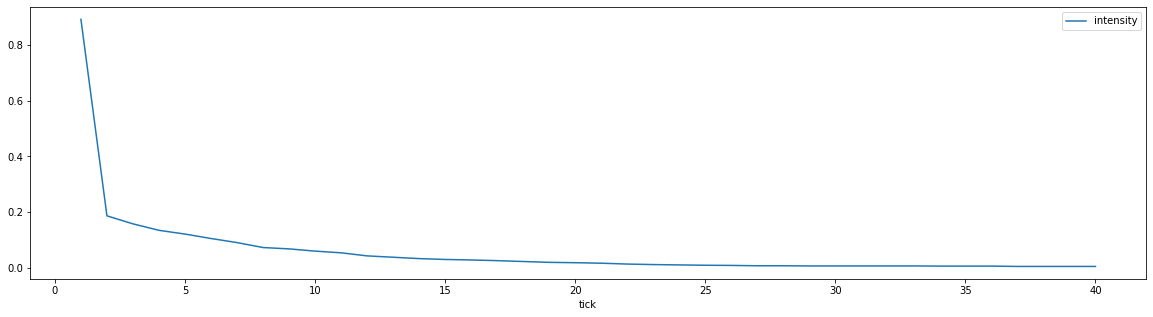

In [37]:
df_ask.plot(x='tick', y=['intensity'])

<AxesSubplot:xlabel='tick'>

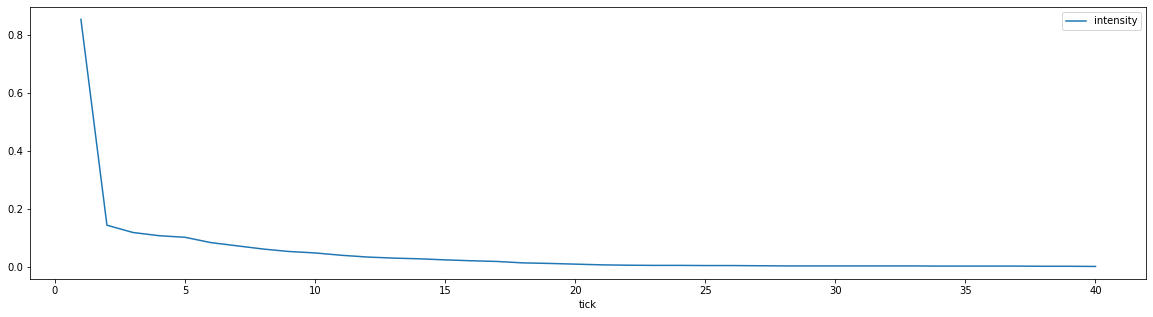

In [38]:
df_bid.plot(x='tick', y=['intensity'])

In [18]:
# estimate k using linear regression
from sklearn.linear_model import LinearRegression
X = df_ask.tick.to_numpy()[:, np.newaxis]
y = np.log(df_ask.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_ask = - reg.coef_[0]
A_ask = np.exp(reg.intercept_)
print('k: ', k_ask)
print('A: ', A_ask)

r:  0.9247470024706146
k:  0.10926631695186387
A:  0.1895833364768586


In [19]:
X = df_bid.tick.to_numpy()[:, np.newaxis]
y = np.log(df_bid.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_bid = - reg.coef_[0]
A_bid = np.exp(reg.intercept_)
print('k: ', k_bid)
print('A: ', A_bid)

r:  0.9229720133621406
k:  0.12257516381774636
A:  0.16477626558884378


In [20]:
k = np.mean([k_bid, k_ask])
A = np.mean([A_bid, A_ask])
print('k mean: ', k)
print('A mean: ', A)

k mean:  0.11592074038480511
A mean:  0.1771798010328512


In [21]:
A*np.exp(-k * np.arange(40.))
df_ask.loc[:, 'estimated'] = A*np.exp(-k * np.arange(40.))

<AxesSubplot:xlabel='tick'>

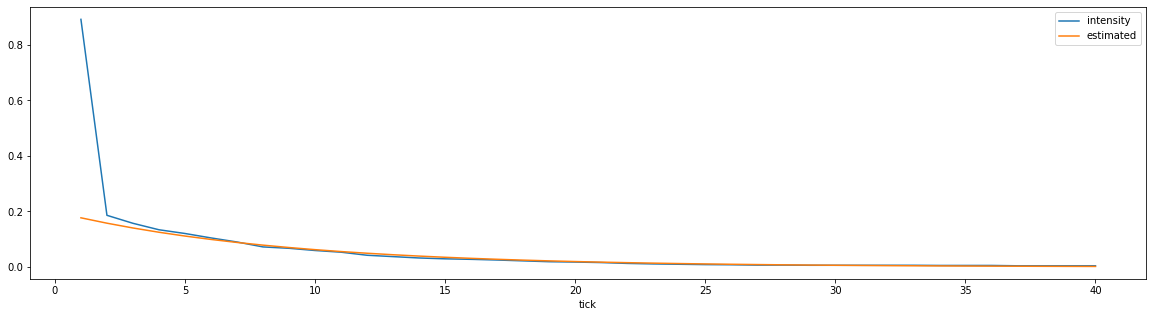

In [22]:
df_ask.plot(x='tick', y=['intensity', 'estimated'])

In this case lower tick intensity are significantly under-estimated

## Parameter estimation: gamma

Gamma is a parameter for market maker's risk aversion factor, there is no easy way which can be detailed in this notebook. It seems this parameter comes from 3 approaches:

- empirical: in lots of literatures this value is 0.1
- machine (reinforcement) learning: see this [repo](https://github.com/im1235/ISAC)

Let me know if you have better findings :D